Cell A (connection)

In [1]:
from pathlib import Path

import sqlite3

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

print("Using DB:", db_path)

print("Exists:", db_path.exists())

print("Size (bytes):", db_path.stat().st_size if db_path.exists() else None) 

conn = sqlite3.connect(db_path)

pd.read_sql_query(

    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    
    conn
)


Using DB: c:\Users\Chino\data_analyst_layer1\data\Synthetic Dataset\product_analytics.db
Exists: True
Size (bytes): 27140096


,name
0,events
1,order_items
2,orders
3,payments
4,products
5,sessions
6,users


Cell B (daily metric df)

In [2]:
query = """

SELECT

    DATE(order_ts) AS day,

    COUNT(*) AS orders,

    SUM(net_revenue) AS revenue,
    
    AVG(net_revenue) AS aov

FROM orders

GROUP BY day

ORDER BY day;

 """

df = pd.read_sql_query(query, conn)

df.head()

,day,orders,revenue,aov
0,2024-01-01,10,1422.22,142.222000
1,2024-01-02,9,1456.57,161.841111
2,2024-01-03,13,1459.21,112.246923
3,2024-01-04,16,2009.31,125.581875
4,2024-01-05,9,1429.87,158.874444


Cell C (inspect)

In [3]:
df.shape, 

df.dtypes

day         object
orders       int64
revenue    float64
aov        float64
dtype: object

Cell D (datetime + monthly) 

In [5]:
df["day"] = pd.to_datetime(df["day"])

df["monthly"] = df["day"].dt.to_period("M")

monthly = (

    df.groupby("monthly")
    
    .agg(revenue=("revenue", "sum"),

        orders=("orders", "sum"),

        aov=("aov", "mean"))
    .reset_index()

)

monthly.head()

,monthly,revenue,orders,aov
0,2024-01,54931.40,370,150.375018
1,2024-02,56993.94,386,146.938193
2,2024-03,61231.93,393,157.158071
3,2024-04,55924.64,358,155.640103
4,2024-05,55941.08,373,149.004778


Cell E (channel revenue)

In [6]:
query = """

SELECT

    u.acquisition_channel,

    sum(o.net_revenue) AS revenue

FROM orders o

JOIN users u ON u.user_id = o.user_id

GROUP BY u.acquisition_channel;

 """

channel_df = pd.read_sql_query(query, conn)

channel_df["pct_revenue"] = channel_df["revenue"] / channel_df["revenue"].sum()

channel_df.sort_values("revenue", ascending=False)

,acquisition_channel,revenue,pct_revenue
2,organic,521764.21,0.375457
3,paid_search,244029.21,0.175601
5,referral,182298.89,0.131181
4,paid_social,171624.30,0.123499
1,email,163246.28,0.117471
0,affiliate,106715.74,0.076792


Cell F (customers)

In [7]:
query = """

SELECT 

    user_id,
    
    SUM(net_revenue) AS lifetime_revenue,

    COUNT(*) AS orders

FROM orders

GROUP BY user_id;

"""

customers = pd.read_sql_query(query, conn)

customers["revenue_per_order"] = customers["lifetime_revenue"] / customers["orders"]

customers.describe()


,user_id,lifetime_revenue,orders,revenue_per_order
count,4194.000000,4194.000000,4194.000000,4194.000000
mean,2505.342394,331.349220,2.145923,154.605567
std,1441.743130,231.087387,1.170906,77.472024
min,1.000000,10.630000,1.000000,10.630000
25%,1255.250000,158.400000,1.000000,99.872500
50%,2507.500000,282.780000,2.000000,145.876667
75%,3755.750000,455.472500,3.000000,198.461875
max,5000.000000,1540.180000,8.000000,649.830000


Cell G (plot)

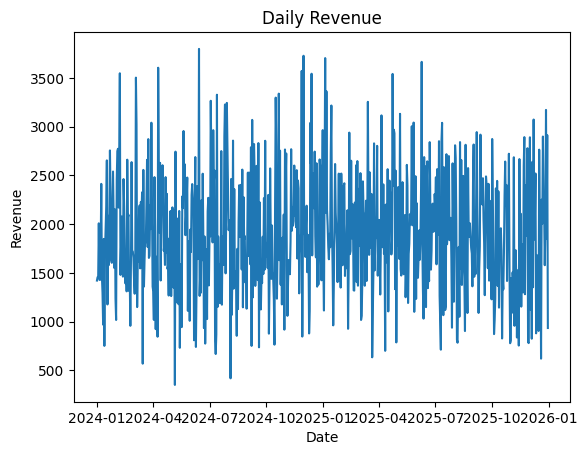

In [8]:
plt.figure()

plt.plot(df["day"], df["revenue"])

plt.title("Daily Revenue")

plt.xlabel("Date")

plt.ylabel("Revenue")

plt.show()

## Key Observations (Day 3)

    - Revenue shows cleafr day to day variability with no obvious long gaps, suggesting stable transaction flow.

    - A small number of acquisition channels contribute to a disproportionate share of revenue.

    - Customer lifetime revenue distribution is right-skewed, including a small cohort of high value users.

## Next Questions

    - How does retention differ by acquisition channel?

    - What does monthly revenue volatility look like?

    - Are high value customers clustered in specific cohorts?